In [1]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import time
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def import_data():
    df_ds1 = pd.read_csv("./winequality-red.csv", sep=";").append(pd.read_csv("./winequality-white.csv", sep=";"))
    missing_values = ['?']
    df_ds2 = pd.read_csv("./breast-cancer-wisconsin.csv", sep=",",na_values = missing_values)
    df_ds2.fillna(method='ffill',inplace=True)
    X_ds1 = np.array(df_ds1.values[:,1:-1])
    y_ds1 = np.array(df_ds1.values[:,-1])
    y_ds1 = (y_ds1<7).astype(int)
    X_ds2 = np.array(df_ds2.values[:,1:-1])
    y_ds2 = np.array(df_ds2.values[:,-1])
    return X_ds1, y_ds1, X_ds2, y_ds2

In [3]:
def train_test(X, y):
    X_train, X_test, y_train, y_test = train_test_split(np.array(X),np.array(y), test_size=0.20)
    sc = preprocessing.StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, X_test, y_train, y_test

In [4]:
def nn_learner(X_train, X_test, y_train, y_test):
    #clf_nn = MLPClassifier(hidden_layer_sizes=(10, 10,10), random_state=18, max_iter=1000)
    __clf_nn = MLPClassifier(hidden_layer_sizes=(20, 20,10),random_state=18)
    print(__clf_nn)
    __clf_nn.fit(X_train, y_train)
    y_pred = __clf_nn.predict(X_test)
    nn_accuracy = metrics.accuracy_score(y_test, y_pred)
    print('Accuracy of neural network without hyperparameter tuning is %.2f%%' % (nn_accuracy * 100))
    return __clf_nn

In [5]:
def __nn_analysis(algorithm,__hidden_layer,__learning_rate,max_iters,max_attempts, X_train, X_test, y_train, y_test,\
                    pop_size = 200, mutation_prob = 0.2,restarts =0,schedule=mlrose.GeomDecay(),random_state=None):

    if algorithm == 'simulated_annealing':
        nn_model1 = mlrose.NeuralNetwork(hidden_nodes =__hidden_layer, activation = 'relu', algorithm = algorithm,
                                max_iters = max_iters, bias = True, is_classifier = True, learning_rate = __learning_rate,
                                early_stopping=True,max_attempts=max_attempts,schedule=schedule,random_state=random_state)
    elif algorithm == 'genetic_alg':
        nn_model1 = mlrose.NeuralNetwork(hidden_nodes = __hidden_layer, activation = 'relu', algorithm = algorithm,
                                max_iters = max_iters, bias = True, is_classifier = True, learning_rate = __learning_rate,
                                early_stopping=True,max_attempts=max_attempts,\
                                pop_size = pop_size, mutation_prob = mutation_prob,random_state=random_state)
    elif algorithm == 'random_hill_climb':
        nn_model1 = mlrose.NeuralNetwork(hidden_nodes = __hidden_layer, activation = 'relu', algorithm = algorithm,
                                max_iters = max_iters, bias = True, is_classifier = True, learning_rate = __learning_rate,
                                early_stopping=True,max_attempts=max_attempts,restarts =restarts,random_state=random_state)
    elif algorithm == 'gradient_descent':
        nn_model1 = mlrose.NeuralNetwork(hidden_nodes = __hidden_layer, activation = 'relu', algorithm = algorithm,
                                max_iters = max_iters, bias = True, is_classifier = True, learning_rate = __learning_rate,
                                early_stopping=True, max_attempts=max_attempts,restarts =restarts,random_state=random_state)
        

    start_time_train = time.time()
    nn_model1.fit(X_train, y_train)
    end_time_train = time.time() - start_time_train
    
    # Predict labels for train set and assess accuracy
    y_train_pred = nn_model1.predict(X_train)
    y_train_accuracy = metrics.accuracy_score(y_train, y_train_pred)
    print('Training accuracy: ', y_train_accuracy)
    
    # Predict labels for test set and assess accuracy
    start_time_pred = time.time()
    y_test_pred = nn_model1.predict(X_test)
    end_time_pred = time.time() - start_time_pred
    
    y_test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
    print('Test accuracy: ', y_test_accuracy)
    
    return y_train_accuracy, y_test_accuracy, end_time_train, end_time_pred

In [6]:
def train_nn_optimization(__hidden_layer,__learning_rate,max_attempts, X_train, X_test,y_train, y_test,\
                            __range=range(1000,10000,1000), pop_size=200, mutation_prob=0.2,restarts =0,schedule=mlrose.GeomDecay(),random_state=None):
    __nn_metrics = {}
    for algorithm in ['random_hill_climb', 'simulated_annealing', 'genetic_alg']:
        __train_accuracy_values, __test_accuracy_values,__train_time_values, __pred_time_values = [],[],[],[]
        for i in __range:
            __train_accuracy, __test_accuracy,__train_time, __pred_time = __nn_analysis(algorithm,__hidden_layer,__learning_rate,i,\
                                                                                          max_attempts, X_train, X_test, \
                                                                                          y_train, y_test,pop_size, \
                                                                                          mutation_prob,restarts,schedule,random_state)
            __train_accuracy_values.append(__train_accuracy)
            __test_accuracy_values.append(__test_accuracy)
            __train_time_values.append(__train_time)
            __pred_time_values.append(__pred_time)
        __nn_metrics[algorithm] = {'train_accuracy' : __train_accuracy_values, 'test_accuracy' : __test_accuracy_values, 'train_time' : __train_time_values,'pred_time' : __pred_time_values}
    return __nn_metrics

In [7]:
def plot_nn_optimization(plot_type,y_axis,results,x_label,y_label,title,filename):
    for algorithm in ['random_hill_climb', 'simulated_annealing', 'genetic_alg'] :
        if plot_type == 'train' :
            plt.plot(y_axis,np.array(results[algorithm]['train_accuracy']),label=algorithm)
        elif plot_type == 'test' :
            plt.plot(y_axis,np.array(results[algorithm]['test_accuracy']),label=algorithm)
        elif plot_type == 'time' :
            plt.plot(y_axis,np.array(results[algorithm]['train_time']),label=algorithm)
        elif plot_type == 'pred' :
            plt.plot(y_axis,np.array(results[algorithm]['pred_time']),label=algorithm)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(loc='best')
    plt.savefig(filename)
    plt.show()
    plt.clf()

In [8]:
def train_nn_backdrop(__hidden_layer,__learning_rate,max_attempts, X_train, X_test,y_train, y_test,\
                        __range=range(1000,10000,1000), pop_size=200, mutation_prob=0.6,restarts =0,schedule=mlrose.GeomDecay(),random_state=None) :
    __nn_metrics = {}
    __train_accuracy_values, __test_accuracy_values,__train_time_values, __pred_time_values = [],[],[],[]
    algorithm = 'gradient_descent'
    for i in __range:
        __train_accuracy, __test_accuracy,__train_time, __pred_time = __nn_analysis(algorithm,__hidden_layer,__learning_rate,i,\
                                                                                          max_attempts, X_train, X_test, \
                                                                                          y_train, y_test,pop_size, \
                                                                                          mutation_prob,restarts,schedule,random_state)
        __train_accuracy_values.append(__train_accuracy)
        __test_accuracy_values.append(__test_accuracy)
        __train_time_values.append(__train_time)
        __pred_time_values.append(__pred_time)
    __nn_metrics[algorithm] = {'train_accuracy' : __train_accuracy_values, 'test_accuracy' : __test_accuracy_values, 'train_time' : __train_time_values,'pred_time' : __pred_time_values}
    return __nn_metrics

In [9]:
def plot_nn_backdrop(plot_type,y_axis,results,x_label,y_label,title,filename):
    algorithm = 'gradient_descent'
    if plot_type == 'train' :
        plt.plot(y_axis,np.array(results[algorithm]['train_accuracy']),label=algorithm)
    elif plot_type == 'test' :
        plt.plot(y_axis,np.array(results[algorithm]['test_accuracy']),label=algorithm)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(loc='best')
    plt.savefig(filename)
    plt.show()
    plt.clf()

In [10]:
def plot_nn_backdrop_both(y_axis,results,x_label,y_label,title,filename):
    algorithm = 'gradient_descent'
    plt.plot(y_axis,np.array(results[algorithm]['train_accuracy']),label=algorithm + ' - train')
    plt.plot(y_axis,np.array(results[algorithm]['test_accuracy']),label=algorithm + ' - test')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(loc='best')
    plt.savefig(filename)
    plt.show()
    plt.clf()

In [11]:
X_ds1, y_ds1, X_ds2, y_ds2 = import_data()
X_train, X_test, y_train, y_test = train_test(X_ds1, y_ds1)
__clf_nn = nn_learner(X_train, X_test, y_train, y_test)

MLPClassifier(hidden_layer_sizes=(20, 20, 10), random_state=18)
Accuracy of neural network without hyperparameter tuning is 83.15%


C:\Dev\Anaconda3\envs\VitrualEnv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
max_attempts = 1000
__range=range(10,6000,5)
__hidden_layer =  list(__clf_nn.hidden_layer_sizes)
#__hidden_layer =  [5]
#__learning_rate = __clf_nn.learning_rate_init
__learning_rate = 0.0001
__nn_metrics_backdrop = train_nn_backdrop(__hidden_layer,__learning_rate,max_attempts, X_train, X_test,y_train, y_test,__range, 200, 0.2,0,mlrose.GeomDecay(),18)


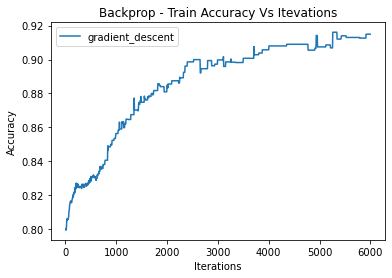

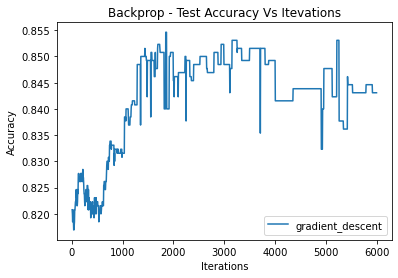

<Figure size 432x288 with 0 Axes>

In [13]:
plot_nn_backdrop('train',__range,__nn_metrics_backdrop,'Iterations','Accuracy','Backprop - Train Accuracy Vs Itevations','./nn_backprop_train_accuracy_iterations10-3.png')
plot_nn_backdrop('test',__range,__nn_metrics_backdrop,'Iterations','Accuracy','Backprop - Test Accuracy Vs Itevations','./nn_backprop_test_accuracy_iterations10-3.png')


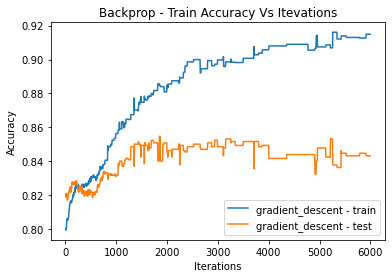

<Figure size 432x288 with 0 Axes>

In [14]:
plot_nn_backdrop_both(__range,__nn_metrics_backdrop,'Iterations','Accuracy','Backprop - Train Accuracy Vs Itevations','./nn_backprop_train_accuracy_iterations10_both-3.png')

In [ ]:
max_attempts = 100
__range=range(1000,100001,10000)
__schedule = mlrose.GeomDecay()
__hidden_layer =  list(__clf_nn.hidden_layer_sizes)
#__hidden_layer =  [5]
#__learning_rate = __clf_nn.learning_rate_init
__learning_rate = 0.1

__nn_metrics_optimization = train_nn_optimization(__hidden_layer,__learning_rate,max_attempts, X_train, X_test,y_train, y_test,__range, 200, 0.2,0,mlrose.GeomDecay(),18)


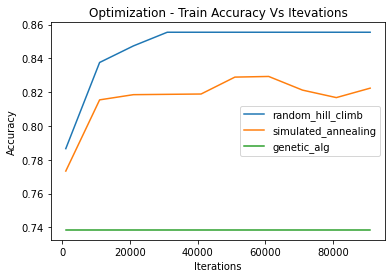

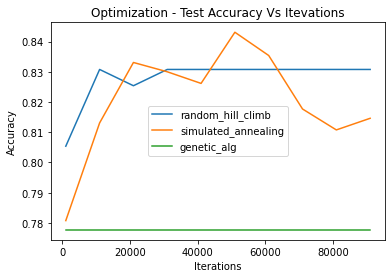

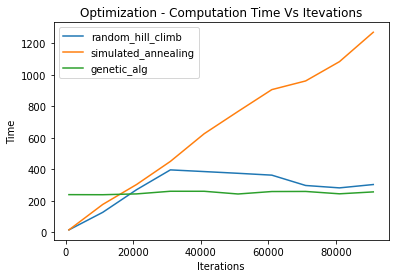

<Figure size 432x288 with 0 Axes>

In [16]:
plot_nn_optimization('train',__range,__nn_metrics_optimization,'Iterations','Accuracy','Optimization - Train Accuracy Vs Itevations','./nn_optimization_train_accuracy_iterations10-3.png')
plot_nn_optimization('test',__range,__nn_metrics_optimization,'Iterations','Accuracy','Optimization - Test Accuracy Vs Itevations','./nn_optimization_test_accuracy_iterations10-3.png')
plot_nn_optimization('time',__range,__nn_metrics_optimization,'Iterations','Time','Optimization - Computation Time Vs Itevations','./nn_optimization_time_accuracy_iterations10-3.png')